# 3D Image Segmentation

## Imports

In [1]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes, label
from scipy.spatial.distance import directed_hausdorff

### Funzioni di I/O DICOM

In [3]:
def load_ct_volume(folder_path):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(folder_path)
    assert series_ids, f"Nessuna serie DICOM in {folder_path}"
    file_names = reader.GetGDCMSeriesFileNames(folder_path, series_ids[0])
    reader.SetFileNames(file_names)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)  # [z,y,x]
    # Recupera e applica RescaleSlope/Intercept se presenti
    slope = float(img.GetMetaData('0028|1053')) if img.HasMetaDataKey('0028|1053') else 1.0
    intercept = float(img.GetMetaData('0028|1052')) if img.HasMetaDataKey('0028|1052') else 0.0
    arr = arr * slope + intercept
    print(f"[IO-CT] {os.path.basename(folder_path)} → shape={arr.shape}, spacing={img.GetSpacing()}, slope={slope}, intercept={intercept}")
    return img, arr


def load_segmentation(dcm_path, ref_img):
    seg = sitk.ReadImage(dcm_path)
    # Estrai i frame e le slice originali
    frames = sitk.GetArrayFromImage(seg)
    n_frames = frames.shape[0] if frames.ndim==3 else 1
    print(f"[IO-SEG] {os.path.basename(dcm_path)} → NumFrames={n_frames}")
    # Prepara volume 0-filled con stesso numero slice di ref_img
    depth, height, width = ref_img.GetSize()[2], ref_img.GetSize()[1], ref_img.GetSize()[0]
    full_mask = np.zeros((depth, height, width), dtype=np.uint8)
    # Leggi mapping da PerFrameFunctionalGroupsSequence
    seq = seg.GetMetaData('PerFrameFunctionalGroupsSequence') if seg.HasMetaDataKey('PerFrameFunctionalGroupsSequence') else None
    # In SimpleITK non parse Diretto, useremo pydicom per mapping
    import pydicom
    ds = pydicom.dcmread(dcm_path)
    for idx, frame in enumerate(ds.PerFrameFunctionalGroupsSequence):
        zpos = float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
        # trova slice index in ref_img
        slice_indices = [i for i in range(depth)
                         if np.isclose(ref_img.TransformIndexToPhysicalPoint((0,0,i))[2], zpos)]
        assert slice_indices, f"Slice non trovata per z={zpos}"
        iz = slice_indices[0]
        full_mask[iz] = (frames[idx] > 0)
        print(f"  - Frame {idx} → z_phys={zpos:.2f} mm → slice_index={iz}")
    return seg, full_mask

### Load dataset

In [4]:
base = "../dataset"
ref_ct, ref_vol = load_ct_volume(os.path.join(base, "10_AP_Ax2.50mm"))
inp_ct, inp_vol = load_ct_volume(os.path.join(base, "30_EQP_Ax2.50mm"))
seg_img, ref_mask_full = load_segmentation(os.path.join(base, "10_AP_Ax2.50mm_ManualROI_Tumor.dcm"), ref_ct)

[IO-CT] 10_AP_Ax2.50mm → shape=(207, 512, 512), spacing=(0.78125, 0.78125, 2.5), slope=1.0, intercept=0.0
[IO-CT] 30_EQP_Ax2.50mm → shape=(111, 512, 512), spacing=(0.78125, 0.78125, 2.5), slope=1.0, intercept=0.0
[IO-SEG] 10_AP_Ax2.50mm_ManualROI_Tumor.dcm → NumFrames=15
  - Frame 0 → z_phys=-117.50 mm → slice_index=152
  - Frame 1 → z_phys=-115.00 mm → slice_index=153
  - Frame 2 → z_phys=-70.00 mm → slice_index=171
  - Frame 3 → z_phys=-67.50 mm → slice_index=172
  - Frame 4 → z_phys=-65.00 mm → slice_index=173
  - Frame 5 → z_phys=-62.50 mm → slice_index=174
  - Frame 6 → z_phys=-60.00 mm → slice_index=175
  - Frame 7 → z_phys=-57.50 mm → slice_index=176
  - Frame 8 → z_phys=-55.00 mm → slice_index=177
  - Frame 9 → z_phys=-52.50 mm → slice_index=178
  - Frame 10 → z_phys=-50.00 mm → slice_index=179
  - Frame 11 → z_phys=-47.50 mm → slice_index=180
  - Frame 12 → z_phys=-45.00 mm → slice_index=181
  - Frame 13 → z_phys=-42.50 mm → slice_index=182
  - Frame 14 → z_phys=-40.00 mm → sl

### Calcolo bounding‐box e centroide su reference mask

In [5]:
coords = np.argwhere(ref_mask_full)
zmin, ymin, xmin = coords.min(axis=0)
zmax, ymax, xmax = coords.max(axis=0)
centroid = coords.mean(axis=0).astype(int)
print(f"[STEP 4] Bounding Box Z:[{zmin},{zmax}] Y:[{ymin},{ymax}] X:[{xmin},{xmax}]")
print(f"[STEP 4] Centroid index (z,y,x): {tuple(centroid)}\n")

[STEP 4] Bounding Box Z:[152,183] Y:[198,336] X:[72,306]
[STEP 4] Centroid index (z,y,x): (np.int64(176), np.int64(229), np.int64(117))



### Seed transform

In [7]:
idx = [int(centroid[2]), int(centroid[1]), int(centroid[0])]
world = ref_ct.TransformIndexToPhysicalPoint(idx)
seed_idx = inp_ct.TransformPhysicalPointToIndex(world)
print(f"[STEP 5] Centroid physical coords: {tuple(world)}")
print(f"[STEP 5] Seed index su 30_EQP: (z,y,x)={seed_idx[::-1]}\n")

[STEP 5] Centroid physical coords: (-121.59375, 69.90625, -57.5)
[STEP 5] Seed index su 30_EQP: (z,y,x)=(71, 229, 127)



### Region Growing nel Bounding Box

In [8]:
class RegionGrowing3D:
    def __init__(self, volume, lower=-100, upper=200, roi=None):
        self.vol = volume
        self.lower, self.upper = lower, upper
        self.roi = roi  # ((z0,z1),(y0,y1),(x0,x1))
    def segment(self, seed):
        mask = np.zeros_like(self.vol, dtype=bool)
        stack = [seed]
        while stack:
            z,y,x = stack.pop()
            if not mask[z,y,x] and self.lower <= self.vol[z,y,x] <= self.upper:
                mask[z,y,x] = True
                for dz,dy,dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
                    nz,ny,nx = z+dz, y+dy, x+dx
                    if 0<=nz<mask.shape[0] and 0<=ny<mask.shape[1] and 0<=nx<mask.shape[2]:
                        stack.append((nz,ny,nx))
        return mask.astype(np.uint8)

# Definiamo ROI per velocizzare (bounding box + margine 5 voxel)
zb, yb, xb = (zmin, zmax), (ymin, ymax), (xmin, xmax)
roi = ((max(0,zb[0]-5), min(ref_vol.shape[0]-1,zb[1]+5)),
       (max(0,yb[0]-5), min(ref_vol.shape[1]-1,yb[1]+5)),
       (max(0,xb[0]-5), min(ref_vol.shape[2]-1,xb[1]+5)))
rg = RegionGrowing3D(inp_vol, lower=-50, upper=150, roi=roi)
auto_raw = rg.segment(seed_idx[::-1])

### Post‐processing

In [9]:
def clean_mask(mask, min_vox=500):
    fill = binary_fill_holes(mask)
    labs, n = label(fill)
    out = np.zeros_like(mask)
    for lab in range(1, n+1):
        comp = (labs==lab)
        if comp.sum()>=min_vox:
            out[comp] = 1
    return out

auto_mask = clean_mask(auto_raw)
print(f"Post-processing: voxels rimossi = {auto_raw.sum()-auto_mask.sum()}\n")

Post-processing: voxels rimossi = 18446744073709515388



C:\Users\giova\AppData\Local\Temp\ipykernel_10748\500221350.py:12: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Post-processing: voxels rimossi = {auto_raw.sum()-auto_mask.sum()}\n")


### Classe per le metriche

In [11]:
# --- Resample della maschera di GT sul grid del CT di input ---
# seg_img: SimpleITK Image della segmentazione originale su ref_ct
# inp_ct:  SimpleITK Image del CT 30_EQP

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(inp_ct)
resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # mantiene binarietà
seg_resampled = resampler.Execute(seg_img)

# Estrai array binario resampled (shape = inp_vol.shape)
ref_mask_on_input = sitk.GetArrayFromImage(seg_resampled).astype(np.uint8)

# --- Classi e calcolo metriche --- 
class EvalMetrics:
    @staticmethod
    def dice(gt, pred):
        inter = np.logical_and(gt, pred).sum()
        return 2 * inter / (gt.sum() + pred.sum())

    @staticmethod
    def jaccard(gt, pred):
        inter = np.logical_and(gt, pred).sum()
        uni   = np.logical_or(gt, pred).sum()
        return inter / uni

    @staticmethod
    def vol_diff(gt, pred, spacing):
        voxel_vol = np.prod(spacing)  # mm³
        return abs(pred.sum() - gt.sum()) * voxel_vol / 1000  # in cm³

# Calcolo delle metriche sullo stesso grid
dice_v = EvalMetrics.dice(ref_mask_on_input, auto_mask)
jac_v  = EvalMetrics.jaccard(ref_mask_on_input, auto_mask)
vdiff  = EvalMetrics.vol_diff(ref_mask_on_input, auto_mask, inp_ct.GetSpacing())

print(f"Dice: {dice_v:.4f}, Jaccard: {jac_v:.4f}, Volume diff: {vdiff:.2f} cm³\n")

Dice: 0.0015, Jaccard: 0.0010, Volume diff: 7032.59 cm³



### Visualizzazione slice con overlay

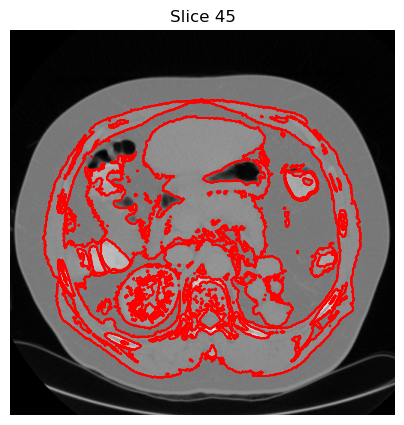

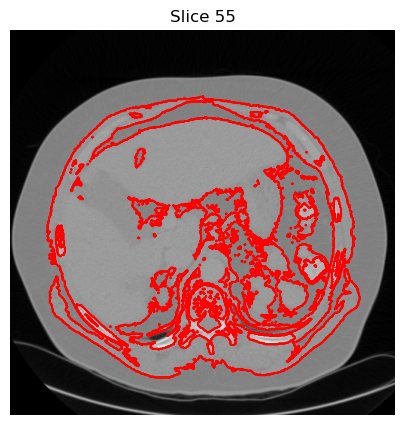

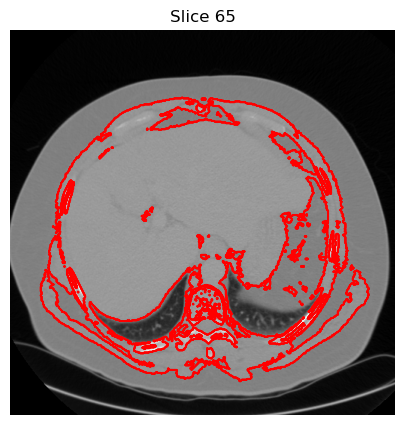

[STEP 9] Visualizzazioni completate.


In [ ]:
def overlay_slice(ct, gt, auto, z):
    plt.figure(figsize=(5,5))
    plt.imshow(ct[z], cmap='gray')
    plt.contour(gt[z], colors='g', linewidths=1)
    plt.contour(auto[z], colors='r', linewidths=1)
    plt.title(f"Slice {z}")
    plt.axis('off')
    plt.show()

# Se hai già fatto il resample:
#   ref_mask_on_input = sitk.GetArrayFromImage(seg_resampled).astype(np.uint8)
# Altrimenti usa ref_mask_full ma assicurati che abbia la stessa shape di inp_vol.

mid_inp = inp_vol.shape[0] // 2

for dz in [-10, 0, 10]:
    z = mid_inp + dz
    if 0 <= z < inp_vol.shape[0]:
        # usa ref_mask_on_input se presente, altrimenti ref_mask_full
        overlay_slice(inp_vol, ref_mask_on_input, auto_mask, z)
    else:
        print(f"Slice {z} fuori limiti (0–{inp_vol.shape[0]-1}), skipping")